In [3]:
#IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [21]:
# READ IN PATH DATA
path = pd.read_csv("path.csv")
print(path.head(122))


     Unnamed: 0  index       x_pth       y_pth         z_pth  \
0             0    177  450.000000  700.000000  1.136868e-13   
1             1    178  450.000000  700.000000  0.000000e+00   
2             2    179  450.000000  700.000000  0.000000e+00   
3             3    180  450.000000  700.000000  0.000000e+00   
4             4    181  450.000000  700.000000  0.000000e+00   
..          ...    ...         ...         ...           ...   
117         117    294  450.000000  700.000000  0.000000e+00   
118         118    295  450.000000  700.000000  0.000000e+00   
119         119    296  450.000000  700.000000  0.000000e+00   
120         120    297  452.904966  699.539899  0.000000e+00   
121         121    298  464.524829  697.699493  0.000000e+00   

                   t_pth  
0    1633969004350000000  
1    1633969004400000000  
2    1633969004450000000  
3    1633969004500000000  
4    1633969004550000000  
..                   ...  
117  1633969010200000000  
118  1633969010

In [22]:
# READ IN TRACKER DATA
tracker = pd.read_csv("tracker.csv")
print(tracker.head(500))

     Unnamed: 0  index      x_trk      y_trk        z_trk                t_trk
0             0   3180 -36.507133 -40.170982 -2915.784424  1633969004633871000
1             1   3181 -36.543438 -40.260765 -2915.713623  1633969004648860000
2             2   3182 -36.645119 -40.364326 -2915.732910  1633969004662330000
3             3   3183 -36.709301 -40.413754 -2915.772949  1633969004674115000
4             4   3184 -36.720108 -40.421989 -2915.788086  1633969004687849000
..          ...    ...        ...        ...          ...                  ...
495         495   3675 -48.926826 -26.074509 -2961.823486  1633969011236526000
496         496   3676 -48.870758 -26.074509 -2961.822021  1633969011247954000
497         497   3677 -48.848335 -26.070332 -2961.819824  1633969011260401000
498         498   3678 -48.854256 -26.070070 -2961.825684  1633969011275453000
499         499   3679 -48.875694 -26.077665 -2961.834717  1633969011287840000

[500 rows x 6 columns]


In [6]:
# GET NUMPY ARRAYS OF IMPORTANT DATA

# path data
pth_x = path["x_pth"].to_numpy()
pth_y = path["y_pth"].to_numpy()
pth_z = path["z_pth"].to_numpy()
pth_t = path["t_pth"].to_numpy()

# tracker data
trk_x = tracker["x_trk"].to_numpy()
trk_y = tracker["y_trk"].to_numpy()
trk_z = tracker["z_trk"].to_numpy()
trk_t = tracker["t_trk"].to_numpy()



In [34]:
merged = pd.merge_asof(path, tracker, left_on='t_pth', right_on='t_trk', direction='nearest')

# path data
pth_x_m = merged["x_pth"].to_numpy()
pth_y_m = merged["y_pth"].to_numpy()
pth_z_m = merged["z_pth"].to_numpy()
pth_t_m = merged["t_pth"].to_numpy()

# tracker data
trk_x_m = merged["x_trk"].to_numpy()
trk_y_m = merged["y_trk"].to_numpy()
trk_z_m = merged["z_trk"].to_numpy()
trk_t_m = merged["t_trk"].to_numpy()

# no longer need pd dataframes 
del path, tracker

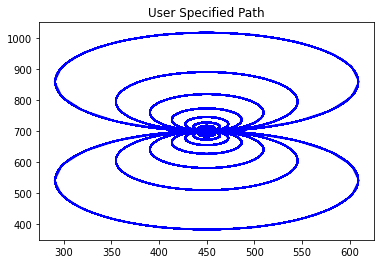

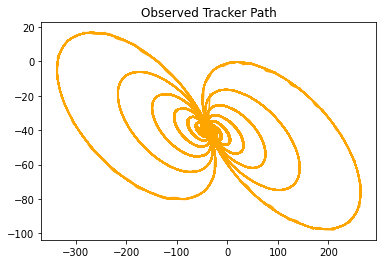

In [7]:
# EXPLORE DESIRED SPECIFIED PATH AND OBSERVED TRACKED PATH

# specified path
plt.plot(pth_x, pth_y, c='blue')
plt.title("User Specified Path")
plt.show()

# tracked path
plt.plot(trk_x, trk_y, c='orange')
plt.title("Observed Tracker Path")
plt.show()

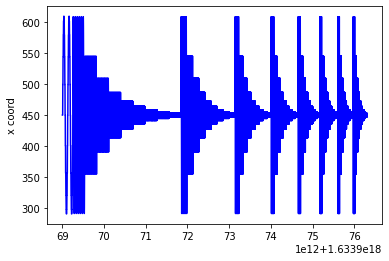

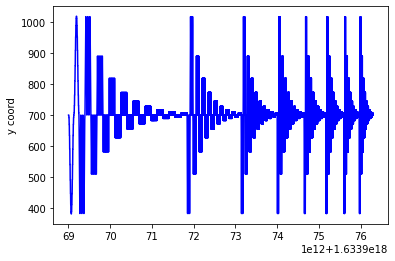

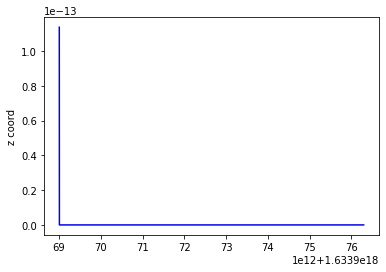

In [8]:
# EXPLROE SPECIFIED PATH VS TIME

plt.plot(pth_t, pth_x, c='blue')
plt.ylabel('x coord')
plt.show()

plt.plot(pth_t, pth_y, c='blue')
plt.ylabel('y coord')
plt.show()

plt.plot(pth_t, pth_z, c='blue')
plt.ylabel('z coord')
plt.show()

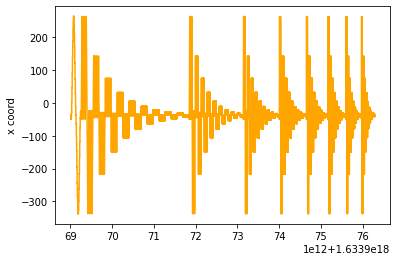

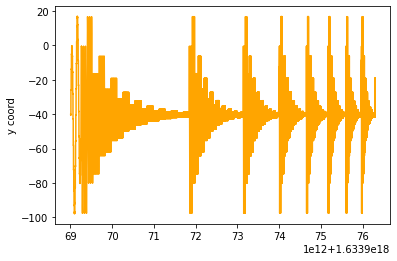

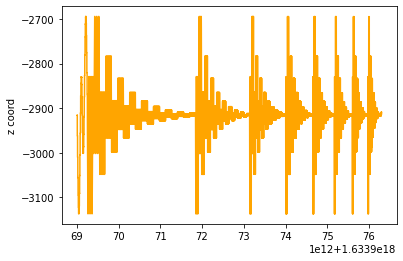

In [9]:
# EXPLORE TRACKER COORDINATES VS TIME
plt.plot(trk_t, trk_x, c='orange')
plt.ylabel('x coord')
plt.show()

plt.plot(trk_t, trk_y, c='orange')
plt.ylabel('y coord')
plt.show()

plt.plot(trk_t, trk_z, c='orange')
plt.ylabel('z coord')
plt.show()

In [10]:
path_size = pth_t.size
tracker_size = trk_t.size
size_ratio = tracker_size / path_size

num_points = 50000
trk_num_points = round(num_points*size_ratio)

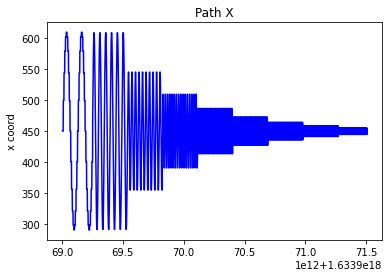

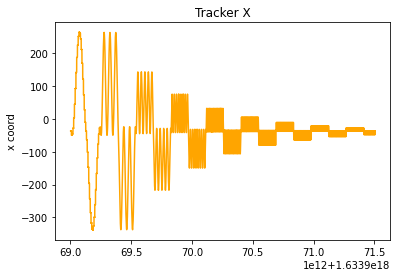

In [11]:
plt.plot(pth_t[:num_points], pth_x[:num_points], c='blue')
plt.ylabel('x coord')
plt.title("Path X")
plt.show()

plt.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt.ylabel('x coord')
plt.title("Tracker X")
plt.show()

## both seem sinusodial but there seem to be very few similarities

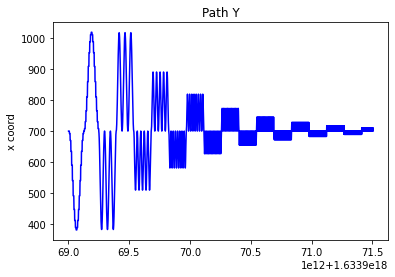

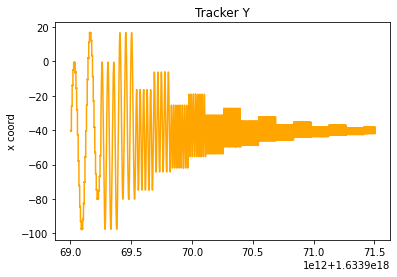

In [14]:
plt.plot(pth_t[:num_points], pth_y[:num_points], c='blue')
plt.ylabel('x coord')
plt.title("Path Y")
plt.show()

plt.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt.ylabel('x coord')
plt.title("Tracker Y")
plt.show()

## both seem to be sinusodial in some sense, but are displaying quite different patterns
## tracker y looks oddly like path x tho

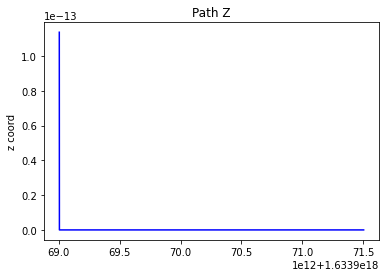

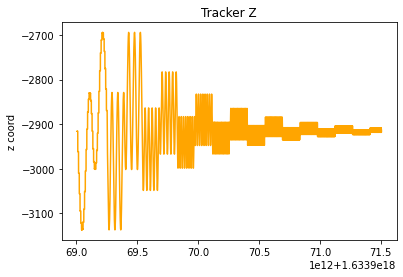

In [15]:
plt.plot(pth_t[:num_points], pth_z[:num_points], c='blue')
plt.ylabel('z coord')
plt.title("Path Z")
plt.show()

plt.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt.ylabel('z coord')
plt.title("Tracker Z")
plt.show()

## absolutely no correlation,, why does tracker have z coordinate?? perhaps this is necessary when robot is in motion? 

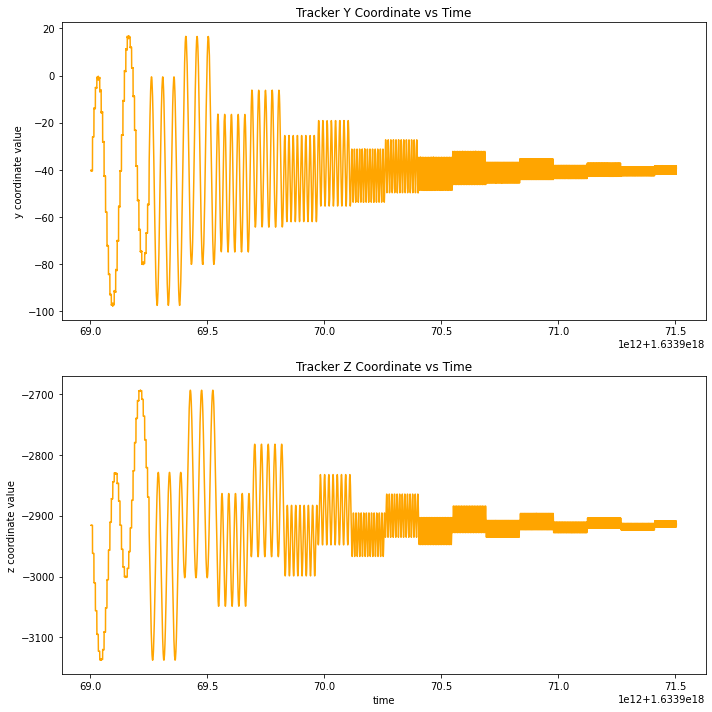

In [16]:
figure, axes = plt.subplots(2,1, figsize=(10,10))

plt1 = axes[0]
plt1.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
#plt1.set_xlabel("time")
plt1.set_ylabel('y coordinate value')
plt1.set_title("Tracker Y Coordinate vs Time")


plt2 = axes[1]
plt2.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt2.set_xlabel("time")
plt2.set_ylabel('z coordinate value')
plt2.set_title("Tracker Z Coordinate vs Time")

plt.tight_layout()
plt.show()
## these two plots show same exact trend

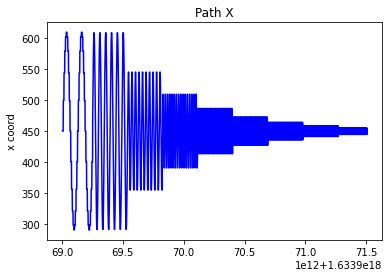

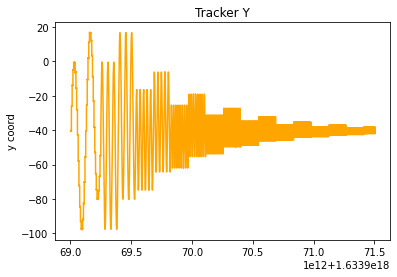

In [17]:
plt.plot(pth_t[:num_points], pth_x[:num_points], c='blue')
plt.ylabel('x coord')
plt.title("Path X")
plt.show()

plt.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt.ylabel('y coord')
plt.title("Tracker Y")
plt.show()

## find error between these two using RMSE??

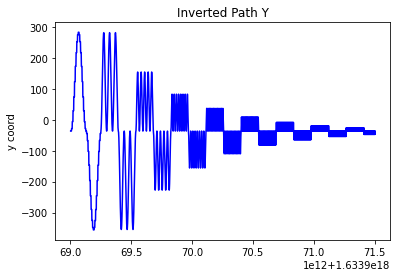

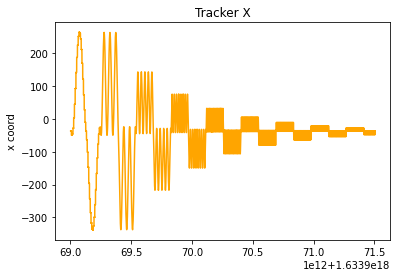

In [32]:
# first point of path y
first_point_diff = -1*pth_y[0] - trk_x[0]

transformed_pth_y = -1*pth_y[:num_points] - first_point_diff

plt.plot(pth_t[:num_points], transformed_pth_y, c='blue')
plt.ylabel('y coord')
plt.title("Inverted Path Y")
plt.show()

plt.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt.ylabel('x coord')
plt.title("Tracker X")
plt.show()

## find error between these two using RMSE??

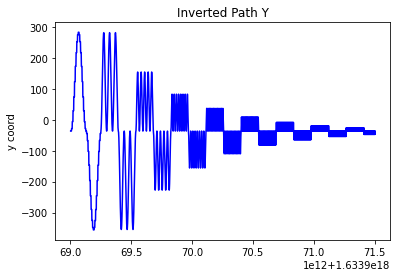

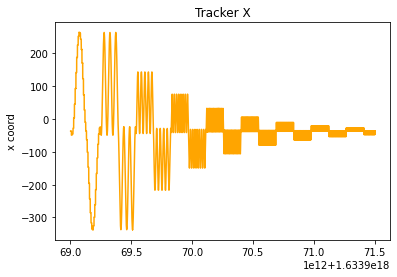

16.512014511746084


In [38]:
# first point of path y
first_point_diff = -1*pth_y_m[0] - trk_x_m[0]

transformed_pth_y_m = -1*pth_y_m[:num_points] - first_point_diff

plt.plot(pth_t_m[:num_points], transformed_pth_y_m, c='blue')
plt.ylabel('y coord')
plt.title("Inverted Path Y")
plt.show()

plt.plot(trk_t_m[:num_points], trk_x_m[:num_points], c='orange')
plt.ylabel('x coord')
plt.title("Tracker X")
plt.show()


print(mae(transformed_pth_y_m, trk_x_m[:num_points]))

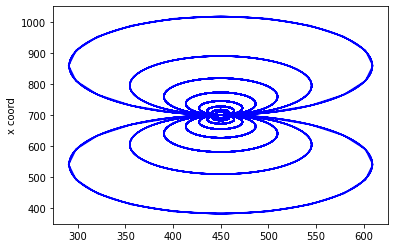

In [ ]:
plt.plot(pth_x[:num_points], pth_y[:num_points], c='blue')
plt.ylabel('x coord')
plt.show()

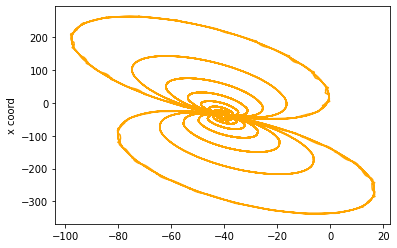

In [ ]:
plt.plot(trk_y[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt.ylabel('x coord')
plt.show()

In [ ]:
max_path_y = max(pth_y[:num_points])
min_path_y = min(pth_y[:num_points])

print(max_path_y)
print(min_path_y)
print(max_path_y-min_path_y)

print()

max_trk_x = max(trk_x[:trk_num_points])
min_trk_x = min(trk_x[:trk_num_points])

print(max_trk_x)
print(min_trk_x)
print(max_trk_x-min_trk_x)

1019.6226610749832
380.37733892501694
639.2453221499662

264.4008178710937
-337.9033203125
602.3041381835938
